<a href="https://colab.research.google.com/github/roshan-varadhan/spotify-playlist-recommender/blob/main/spotify_playlist_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importing Libraries**

In [1]:
!pip install spotipy
!pip install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.1/252.1 kB 4.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import os
from dotenv import load_dotenv
from pathlib import Path

# Connecting to Spotify

In [4]:
#Authentication
load_dotenv(dotenv_path=Path('/content/variables.env'))
cid = os.getenv('CLIENT_ID')
secret = os.getenv('CLIENT_SECRET')

client_credentials_mgmt = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_mgmt)

## Playlist Dataframe

In [58]:
playlist_link = input("Enter the playlist link: ")

# Extract playlist URI from the link
playlist_URI = playlist_link.split("/")[-1].split("?")[0]

# Function to handle retries
def fetch_with_retry(func, *args, retries=5, delay=1, backoff=2, **kwargs):
    for i in range(retries):
        try:
            return func(*args, **kwargs)
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get('Retry-After', delay))
                print(f"Rate limited. Retrying in {retry_after} seconds...")
                time.sleep(retry_after)
                delay *= backoff
            else:
                raise e
    raise Exception("Max retries exceeded")

# Fetch playlist details
playlist_details = fetch_with_retry(sp.playlist, playlist_URI)

# Get playlist name and user display name
playlist_name = playlist_details['name']
user_display_name = playlist_details['owner']['display_name']

# Fetch all playlist tracks with pagination
def get_all_tracks(playlist_URI):
    tracks = []
    offset = 0
    while True:
        response = fetch_with_retry(sp.playlist_tracks, playlist_URI, offset=offset)
        tracks.extend(response['items'])
        if len(response['items']) < 100:
            break
        offset += 100
    return tracks

tracks = get_all_tracks(playlist_URI)

# Extract track details
track_uris = [item["track"]["uri"] for item in tracks]

# Batch URIs for audio features
def get_audio_features(track_uris):
    audio_features = []
    for i in range(0, len(track_uris), 100):
        batch = track_uris[i:i+100]
        features = fetch_with_retry(sp.audio_features, batch)
        audio_features.extend(features)
    return audio_features

# Fetch audio features for the tracks
audio_features = get_audio_features(track_uris)

# Combine track details with audio features
track_data = []
for item, features in zip(tracks, audio_features):
    if features:
      track = item["track"]
      track_name = track["name"]
      artist_name = track["artists"][0]["name"]  # Assuming the first artist is the main artist
      track_uri = track["uri"]

      # Fetch audio features for the track
      audio_features = sp.audio_features(track_uri)[0]
      danceability = audio_features['danceability']
      energy = audio_features['energy']
      liveness = audio_features['liveness']
      key = audio_features['key']
      mode = audio_features['mode']
      loudness = audio_features['loudness']
      speechiness = audio_features['speechiness']
      acousticness = audio_features['acousticness']
      instrumentalness = audio_features['instrumentalness']
      valence = audio_features['valence']
      tempo = audio_features['tempo']

      track_data.append([track_name, artist_name, danceability, energy, liveness, key, mode, loudness, speechiness, acousticness, instrumentalness, valence, tempo])

# Create a DataFrame
df_playlist = pd.DataFrame(track_data, columns=["Track Name", "Artist", "Danceability", "Energy", "Liveness","Key","Mode","Loudness","Speechiness","Acousticness","Instrumentalness","Valence", "Tempo"])
df_playlist.head()

Enter the playlist link: https://open.spotify.com/playlist/2HszhdFnerlWGixTd1825K?si=9d4aae38a6704e98


,Track Name,Artist,Danceability,Energy,Liveness,Key,Mode,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Tempo
0,Rose In Harlem,Teyana Taylor,0.543,0.567,0.1710,2,0,-5.241,0.1290,0.4670,0.000000,0.3510,143.731
1,Starboy,The Weeknd,0.679,0.587,0.1370,7,1,-7.015,0.2760,0.1410,0.000006,0.4860,186.003
2,I Feel It Coming,The Weeknd,0.773,0.819,0.0679,0,0,-5.946,0.1180,0.4280,0.000000,0.5850,92.987
3,The Hills,The Weeknd,0.585,0.564,0.1350,0,0,-7.063,0.0515,0.0671,0.000000,0.1370,113.003
4,Often,The Weeknd,0.572,0.631,0.1350,7,0,-9.836,0.0476,0.2220,0.000000,0.0713,134.078


## Loading the Data into a Pandas DataFrame

In [60]:
df = pd.read_csv("playlist_2010to2023.csv", encoding='latin-1')
df.dropna(inplace=True)
# Drop Unnecessary Columns
df.drop(['year','artist_genres','playlist_url','track_id','track_popularity','artist_id','artist_popularity','time_signature', 'duration_ms'], axis=1, inplace=True)
df.head()


,track_name,album,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Oops!...I Did It Again,Oops!... I Did It Again,Britney Spears,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053
1,All The Small Things,Enema Of The State,blink-182,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726
2,Breathe,Breathe,Faith Hill,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859
3,It's My Life,Crush,Bon Jovi,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992
4,Bye Bye Bye,No Strings Attached,*NSYNC,0.610,0.926,8,-4.843,0,0.0479,0.0310,0.001200,0.0821,0.861,172.638


## Dropping Features and Combining Data

In [61]:
# Create a new DataFrame with only necessary columns
dropped_df = df[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
dropped_df_playlist = df_playlist.drop(['Track Name', 'Artist'], axis=1)


In [62]:
# Congregate playlist averages into one representative 'song' to be used for comparison
# Convert column names to lowercase to match expected keys
dropped_df_playlist.columns = dropped_df_playlist.columns.str.lower()

means= dropped_df_playlist.mean()
dropped_df.loc[len(dropped_df.index)] = means
df.loc[len(df.index)] = [playlist_name,'', user_display_name, means['danceability'], means['energy'], means['key'], means['loudness'], means['mode'], means['speechiness'], means['acousticness'], means['instrumentalness'], means['liveness'], means['valence'], means['tempo']]
df

<ipython-input-62-63d52c7487e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_df.loc[len(dropped_df.index)] = means


,track_name,album,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Oops!...I Did It Again,Oops!... I Did It Again,Britney Spears,0.751000,0.83400,1.00000,-5.444000,0.000000,0.043700,0.300000,0.000018,0.355000,0.894000,95.053000
1,All The Small Things,Enema Of The State,blink-182,0.434000,0.89700,0.00000,-4.918000,1.000000,0.048800,0.010300,0.000000,0.612000,0.684000,148.726000
2,Breathe,Breathe,Faith Hill,0.529000,0.49600,7.00000,-9.007000,1.000000,0.029000,0.173000,0.000000,0.251000,0.278000,136.859000
3,It's My Life,Crush,Bon Jovi,0.551000,0.91300,0.00000,-4.063000,0.000000,0.046600,0.026300,0.000013,0.347000,0.544000,119.992000
4,Bye Bye Bye,No Strings Attached,*NSYNC,0.610000,0.92600,8.00000,-4.843000,0.000000,0.047900,0.031000,0.001200,0.082100,0.861000,172.638000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2396,QLONA,MAÑANA SERÁ BONITO (BICHOTA SEASON),KAROL G,0.842000,0.75600,7.00000,-7.409000,0.000000,0.338000,0.525000,0.000002,0.087100,0.421000,169.925000
2397,LOVE AGAIN,LOVE AGAIN,The Kid LAROI,0.662000,0.39800,11.00000,-6.691000,0.000000,0.027500,0.716000,0.000000,0.111000,0.468000,107.001000
2398,Feather,emails i cant send fwd:,Sabrina Carpenter,0.787000,0.68600,6.00000,-4.370000,0.000000,0.033900,0.089300,0.000000,0.092700,0.836000,123.510000
2399,Attention,Attention,Doja Cat,0.759000,0.56700,2.00000,-7.911000,1.000000,0.248000,0.118000,0.027800,0.105000,0.421000,87.981000


In [63]:
# Normalizing numerical feature columns
numerical_columns = ['loudness', 'tempo','key']

# Create a copy of the dropped_df
final_df = dropped_df

# Apply min-max scaling to the selected numerical feature columns
final_df[numerical_columns] = (dropped_df[numerical_columns] - dropped_df[numerical_columns].min()) / (dropped_df[numerical_columns].max() - dropped_df[numerical_columns].min())

# Display the finalized df
final_df.head()

<ipython-input-63-6a2f76be6db3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[numerical_columns] = (dropped_df[numerical_columns] - dropped_df[numerical_columns].min()) / (dropped_df[numerical_columns].max() - dropped_df[numerical_columns].min())


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.751,0.834,0.090909,0.751908,0.0,0.0437,0.3000,0.000018,0.3550,0.894,0.232262
1,0.434,0.897,0.000000,0.777159,1.0,0.0488,0.0103,0.000000,0.6120,0.684,0.588095
2,0.529,0.496,0.636364,0.580865,1.0,0.0290,0.1730,0.000000,0.2510,0.278,0.509421
3,0.551,0.913,0.000000,0.818204,0.0,0.0466,0.0263,0.000013,0.3470,0.544,0.397599
4,0.610,0.926,0.727273,0.780759,0.0,0.0479,0.0310,0.001200,0.0821,0.861,0.746622


# Data Analyzation

## Clustering the Data

In [64]:
# Function that works out optimum number of clusters
def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, n_init=max_k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    # Generate the elbow plot
    plt.figure(figsize=(10, 5))  # Create a new figure
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

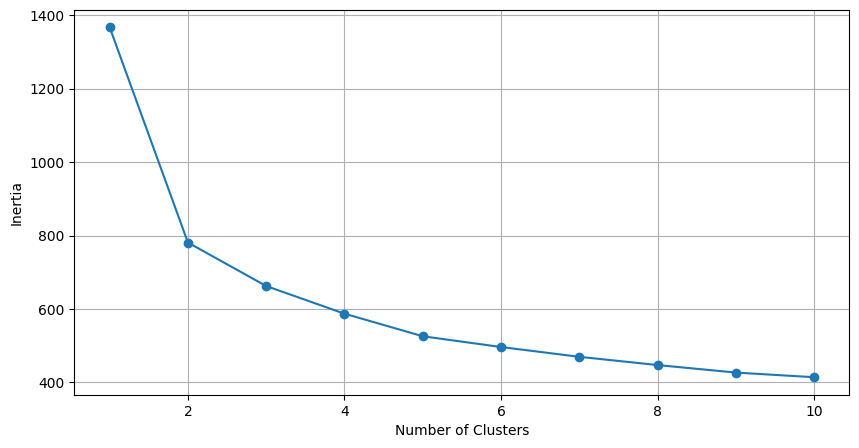

In [65]:
optimise_k_means(final_df, 10)

## Applying K-Means Clustering

In [66]:
# Initialize a KMeans model with 4 clusters
kmeans = KMeans(n_clusters=10, n_init='auto')

# Fit the KMeans model to the data in 'final_df'
kmeans.fit(final_df)

# Assign cluster labels to each data point and add the 'Cluster' column to the original DataFrame
df['Cluster'] = kmeans.labels_
final_df['Cluster'] = kmeans.labels_

<ipython-input-66-c34dd9709eb8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Cluster'] = kmeans.labels_


## Model Visualization

<ipython-input-67-298cb5ff5d61>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['pca_1'] = reduced_features[:, 0]
<ipython-input-67-298cb5ff5d61>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['pca_2'] = reduced_features[:, 1]


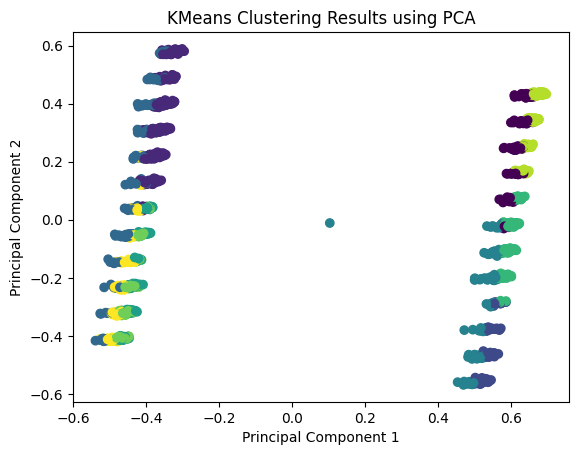

In [67]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(final_df.drop('Cluster', axis=1)) # Exclude the cluster labels

# Add the reduced components to the DataFrame
final_df['pca_1'] = reduced_features[:, 0]
final_df['pca_2'] = reduced_features[:, 1]

# Create a scatter plot
plt.scatter(final_df['pca_1'], final_df['pca_2'], c=final_df['Cluster'], cmap='viridis')
plt.title('KMeans Clustering Results using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Song Recommendations

In [70]:
def find_song_recommendation(track_name, df):
    try:
        # Attempt to find the index of the first occurence of 'track_name' in the 'Track' column of 'df'
        track_index = df[df['track_name'] == track_name].index[0]

        # Create a filter to select rows in 'df' that belong to the same cluster as the provided track
        filter = (df['Cluster'] == df.loc[track_index]['Cluster'])

        # Apply the filter to 'df' to get a DataFrame containing songs from the same cluster
        filtered_df = df[filter]

        # Generate song recommendations by randomly selecting tracks from the same cluster
        for i in range(50):
            # Randomly sample a track from the shuffled DataFrame
            recommendation = filtered_df.sample()
            while recommendation.iloc[0]['track_name'] == track_name:
                recommendation = filtered_df.sample()
            # Print the recommended track's title and artist
            print("'" + recommendation.iloc[0]['track_name'] + "' by " + recommendation.iloc[0]['artist_name'])
    except:
      print("Track not found in the dataset.")

In [71]:
find_song_recommendation(playlist_name, df)

'Love Me Harder' by Ariana Grande
'Sing For The Moment' by Eminem
'Close' by Nick Jonas
'I Miss You (feat. Julia Michaels)' by Clean Bandit
'THE SCOTTS' by THE SCOTTS
'The Kill' by Thirty Seconds To Mars
'Look Back at It' by A Boogie Wit da Hoodie
'Where Are Ü Now (with Justin Bieber)' by Jack Ü
'DÁKITI' by Bad Bunny
'Impossible' by James Arthur
'Nevermind' by Dennis Lloyd
'Drunk in Love (feat. Jay-Z)' by Beyoncé
'Better' by Khalid
'OMG (feat. will.i.am)' by USHER
'I Miss You (feat. Julia Michaels)' by Clean Bandit
'Talking to the Moon' by Bruno Mars
'Animals' by Maroon 5
'Desert Rose' by Sting
'Please Don't Go' by Joel Adams
'Desert Rose' by Sting
'pov' by Ariana Grande
'Second Chance' by Shinedown
'fukumean' by Gunna
'Die For You - Remix' by The Weeknd
'late at night' by Roddy Ricch
'Put Your Records On' by Ritt Momney
'Slow Motion' by Trey Songz
'In the Name of Love' by Martin Garrix
'late at night' by Roddy Ricch
'Cool for the Summer' by Demi Lovato
'Die Hard' by Kendrick Lamar
'Da